# Clustering

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import metrics

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.preprocessing import StandardScaler, PowerTransformer, PolynomialFeatures, MinMaxScaler


In [3]:
df = pd.read_csv('mainset2.csv')
print('SHAPE : ', df.shape) 
df.columns

SHAPE :  (514704, 46)


Index(['date', 'season_id', 'location', 'type', 'outcome', 'difference',
       'game_id', 'team_id', 'team_abb', 'team_city', 'player_id', 'name',
       'start_position', 'age_days', 'height', 'seconds', 'fgm', 'fga', 'fg3m',
       'fg3a', 'ftm', 'fta', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'to',
       'pf', 'pts', 'poss', 'off_rate', 'def_rate', 'net_rate', 'pace',
       'ast_pct', 'ast_tov', 'ast_ratio', 'oreb_pct', 'dreb_pct', 'reb_pct',
       'tm_tov_pct', 'usg_pct', 'game_score', 'plus_minus'],
      dtype='object')

In [4]:
# Display by pts per 40 mins
X = df.groupby(['player_id','name']).mean()
# Create games_played column
X['games_played'] = df.groupby(['player_id','name']).size()
# FG percent
X['fgpct'] = (X['fgm'] / (X['fga'] + .000001))
# FG 3 percent
X['fg3pct'] = (X['fg3m'] / (X['fg3a'] + .000001))
#  FT percent
X['ftpct'] = (X['ftm'] / (X['fta'] + .000001))
# John Hollinger Game Score per 40 mins
X['gs'] = X['pts'] + .4*X['fgm'] - .7*X['fga'] - .4*(X['fta'] - X['ftm']) + .7*X['oreb'] + \
.3*X['dreb'] + X['stl'] + .7*X['ast'] + .7*X['blk'] - .4*X['pf'] - X['to']
# Effective FG%
X['efg_pct'] = (.5*X['fg3m'] + X['fgm']) / X['fga']
# True Shooting %
X['ts_pct'] = X['pts'] / ((.44*X['fta'] +X['fga']*2))

X.drop(columns=['fgm','ftm','fg3m'],inplace=True)
X.columns
X[[col for col in X.loc[:,'pts':]]].sort_values(by='pts', ascending=False).head(20)

pts       poss    off_rate    def_rate  \
player_id name                                                               
947       Allen Iverson       27.712062  82.367056  102.549805  101.432166   
2544      LeBron James        27.365246  75.792787  109.570295  102.068393   
201142    Kevin Durant        27.338399  76.032421  110.043465  103.513880   
977       Kobe Bryant         27.085885  75.909634  107.198058  103.040627   
1629029   Luka Doncic         25.137681  70.108696  110.779710  110.777536   
201935    James Harden        24.943809  70.300728  110.144225  104.626327   
203076    Anthony Davis       24.382143  71.285714  106.828393  105.219107   
203081    Damian Lillard      24.253731  74.911940  109.272090  106.971791   
201939    Stephen Curry       23.991337  73.292079  112.522772  102.806064   
203954    Joel Embiid         23.784483  65.090517  109.174569  101.324569   
2546      Carmelo Anthony     23.627402  71.678363  106.775188  105.160485   
1629027   Trae Young          23.595745  72.106383  107.468085  114.528369   
201566    Russell Westbrook   23.418699  71.593496  108.943801  103.577541   
1628378   Donovan Mitchell    23.100806  70.721774  109.110887  103.880242   
1626164   Devin Booker        22.699115  71.923304  105.271386  110.725959   
202681    Kyrie Irving        22.579932  68.685374  109.014966  106.337415   
1626157   Karl-Anthony Towns  22.559229  70.253444  109.776584  109.953994   
1629627   Zion Williamson     22.500000  61.791667  110.600000  108.604167   
2548      Dwyane Wade         22.047967  67.352033  106.646667  102.377154   
204054    Zoran Dragic        22.000000  85.000000   96.800000  105.000000   

                              net_rate        pace   ast_pct   ast_tov  \
player_id name                                                           
947       Allen Iverson       1.115435   95.622192  0.277911  2.207469   
2544      LeBron James        7.502033   94.855921  0.351666  2.725214   
201142    Kevin Durant        6.530193   98.994336  0.197070  1.781483   
977       Kobe Bryant         4.158701   95.635728  0.245844  2.147380   
1629029   Luka Doncic        -0.005072  101.999058  0.382088  2.428074   
201935    James Harden        5.517482   98.949553  0.318259  2.191530   
203076    Anthony Davis       1.606786   99.285679  0.129650  1.581021   
203081    Damian Lillard      2.297313   99.251134  0.290833  2.889741   
201939    Stephen Curry       9.718441  101.911337  0.292586  2.714532   
203954    Joel Embiid         7.851293  101.618233  0.190230  1.229333   
2546      Carmelo Anthony     1.615789   97.284102  0.157175  1.512822   
1629027   Trae Young         -7.060993  106.973617  0.399113  2.688406   
201566    Russell Westbrook   5.365346   99.721169  0.398174  2.625814   
1628378   Donovan Mitchell    5.227823  100.223226  0.209306  1.812478   
1626164   Devin Booker       -5.456932  103.271003  0.241174  1.793188   
202681    Kyrie Irving        2.675680   97.864065  0.289129  2.776206   
1626157   Karl-Anthony Towns -0.180165   99.508815  0.147850  1.367340   
1629627   Zion Williamson     1.995833  107.292500  0.141952  1.206111   
2548      Dwyane Wade         4.269837   94.785602  0.282397  2.124466   
204054    Zoran Dragic       -8.200000  100.000000  0.091000  0.670000   

                              ast_ratio  oreb_pct  ...   usg_pct  game_score  \
player_id name                                     ...                         
947       Allen Iverson       17.011503  0.034488  ...  0.318815   18.524643   
2544      LeBron James        21.678070  0.048963  ...  0.309762   22.463738   
201142    Kevin Durant        14.554478  0.041478  ...  0.293559   20.668693   
977       Kobe Bryant         16.177128  0.045528  ...  0.315598   18.923600   
1629029   Luka Doncic         21.659124  0.048673  ...  0.325717   19.328261   
201935    James Harden        20.629957  0.041984  ...  0.292139   19.213111   
203076    Anthony Davis       10.568323  0.081673 

In [5]:
import pickle
with open('position_dict.pickle', 'rb') as f:
    position_dict = pickle.load(f)
    
# X['target'] = X.index.map(lambda x: position_dict[x[0]])

In [6]:
X_train = X[[col for col in X.loc[:,'seconds':] if col not in ['games_played']]].copy()
X_train.fillna(0, inplace=True)

no_polynomials = [col for col in X_train.loc[:,'seconds':] if X_train[col].min()<0]
polynomials = [col for col in X_train.loc[:,'seconds':] if col not in no_polynomials]

In [8]:
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin

# class ColumnExtractor(BaseEstimator, TransformerMixin):
#     def __init__(self, columns=None):
#         self.columns = columns
#     def fit(self, X, y=None):
#         return self
#     def transform(self, X):
#         X_cols = X[self.columns]
#         return X_cols

poly_x = X_train[polynomials].copy()
non_poly_x = X_train[no_polynomials].copy()

poly = PolynomialFeatures()

poly_x = pd.DataFrame(poly.fit_transform(poly_x),
                      columns=poly.get_feature_names([c for c in ['1']+polynomials if c!=0]),
                      index=non_poly_x.index)

X_poly = pd.concat([poly_x,non_poly_x], join='outer',axis=1)
del poly_x
del non_poly_x

scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X_poly),
                     columns=X_poly.columns,
                     index=X_poly.index)

pca = PCA()
X_pca = pd.DataFrame(pca.fit_transform(X_std),
                    columns=[f'PC_{c}' for c in range(1,len(X_std.columns)+1)],
                    index=X_std.index)
X_pca

PC_1       PC_2       PC_3       PC_4  \
player_id name                                                          
3         Grant Long       -1.364365   2.607325   1.885435  -2.153874   
15        Eric Piatkowski  -3.241894  -6.065169  -5.311036   4.461232   
21        Greg Anthony     -1.986076 -11.778816   3.729333   1.015456   
22        Rik Smits         7.913964  10.774595  -4.975564  -4.758379   
23        Dennis Rodman    17.987432  37.548985  14.205647  -5.069172   
...                              ...        ...        ...        ...   
1629744   Matt Thomas      -8.044843  -6.053442  -2.572473  11.553329   
1629745   Tariq Owens     -22.232843   2.291511 -12.402496 -10.271472   
1629750   Javonte Green    -8.331334   0.266858   1.221165   5.898614   
1629752   Juwan Morgan    -12.001674   2.930629   3.298875   7.860266   
1629760   Matt Mooney     -24.184952  -4.002535 -12.702867 -15.470592   

                                PC_5      PC_6       PC_7      PC_8  \
player_id name                                                        
3         Grant Long       -3.164660  4.301672  -2.218134 -2.199767   
15        Eric Piatkowski   0.446390  0.458505  -1.618219 -1.191207   
21        Greg Anthony     -1.485828  1.608441  -0.828714 -0.189485   
22        Rik Smits         4.499201  2.435839   3.347981 -2.765125   
23        Dennis Rodman   -14.537251  3.053393 -19.234780  4.920532   
...                              ...       ...        ...       ...   
1629744   Matt Thomas       1.697319 -1.851380   1.635220  1.197679   
1629745   Tariq Owens       1.511120 -3.906353   4.272708 -4.460927   
1629750   Javonte Green     0.006845 -1.120741   1.683231 -0.403098   
1629752   Juwan Morgan     -2.702508 -3.158176   3.109164 -0.296868   
1629760   Matt Mooney     -11.671400 -1.164106   4.678764  0.432496   

                                PC_9     PC_10  ...        PC_491  \
player_id name                                  ...                 
3         Grant Long        2.019298  3.572112  ...  0.000000e+00   
15        Eric Piatkowski  -1.001810  0.109442  ...  8.244905e-16   
21        Greg Anthony     -0.784160  0.768387  ... -3.865704e-16   
22        Rik Smits        -6.818855 -4.992329  ... -8.874123e-17   
23        Dennis Rodman    21.497153 -1.026581  ... -2.225828e-16   
...                              ...       ...  ...           ...   
1629744   Matt Thomas      -0.577344 -0.162604  ...  4.208943e-16   
1629745   Tariq Owens       1.775925  2.493665  ...  5.686981e-17   
1629750   Javonte Green     1.438283  1.424317  ... -1.755002e-16   
1629752   Juwan Morgan      2.765768 -0.434609  ... -1.842911e-16   
1629760   Matt Mooney      -0.589311  4.866901  ... -3.387658e-16   

                                 PC_492        PC_493        PC_494  \
player_id name                                                        
3         Grant Long       0.000000e+00 -0.000000e+00 -0.000000e+00   
15        Eric Piatkowski  8.890071e-16 -2.479748e-16 -2.128013e-16   
21        Greg Anthony    -1.223082e-15  3.267469e-15 -3.691776e-16   
22        Rik Smits       -2.671056e-16 -8.560246e-17 -1.018394e-15   
23        Dennis Rodman    5.216391e-16  4.235421e-16 -6.031756e-16   
...                                 ...           ...           ...   
1629744   Matt Thomas      1.608031e-16 -5.905219e-16 -5.548892e-18   
1629745   Tariq Owens      1.825600e-16  3.027667e-16 -1.490965e-17   
1629750   Javonte Green    4.661285e-16 -6.794536e-16 -8.352027e-16   
1629752   Juwan Morgan     1.537319e-15 -4.372032e-16 -7.239343e-16   
1629760   Matt Mooney      1.602496e-16 -1.333767e-16 -1.568768e-16   

                                 PC_495        PC_496        PC_497  \
player_id name                                                        
3         Grant Long      -0.000000e+00 -0.000000e+00 -0.000000e+00   
15        Eric Piatkowski -1.118977e-15  3.812796e-16 -9.017630e-16   
21        Greg Anthony    -2.854584e-16 -7.023838e-1

In [9]:
# Scree plot
from scikitplot.decomposition import plot_pca_component_variance, plot_pca_2d_projection

plot_pca_component_variance(pca, target_explained_variance=0.95, figsize=(12, 6))
plt.show()

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm


<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [11]:
position_number_dict = {'G':0,'F':1,'C':2,'G/F':3,'F/C':4,'G/F/C':5,'None':6}
number_position_dict = {position_number_dict[i] : i for i in position_number_dict.keys()}

dict_encoded = X_pca.index.map(
    lambda x: position_dict[x[0]]).fillna('None').map(position_number_dict)

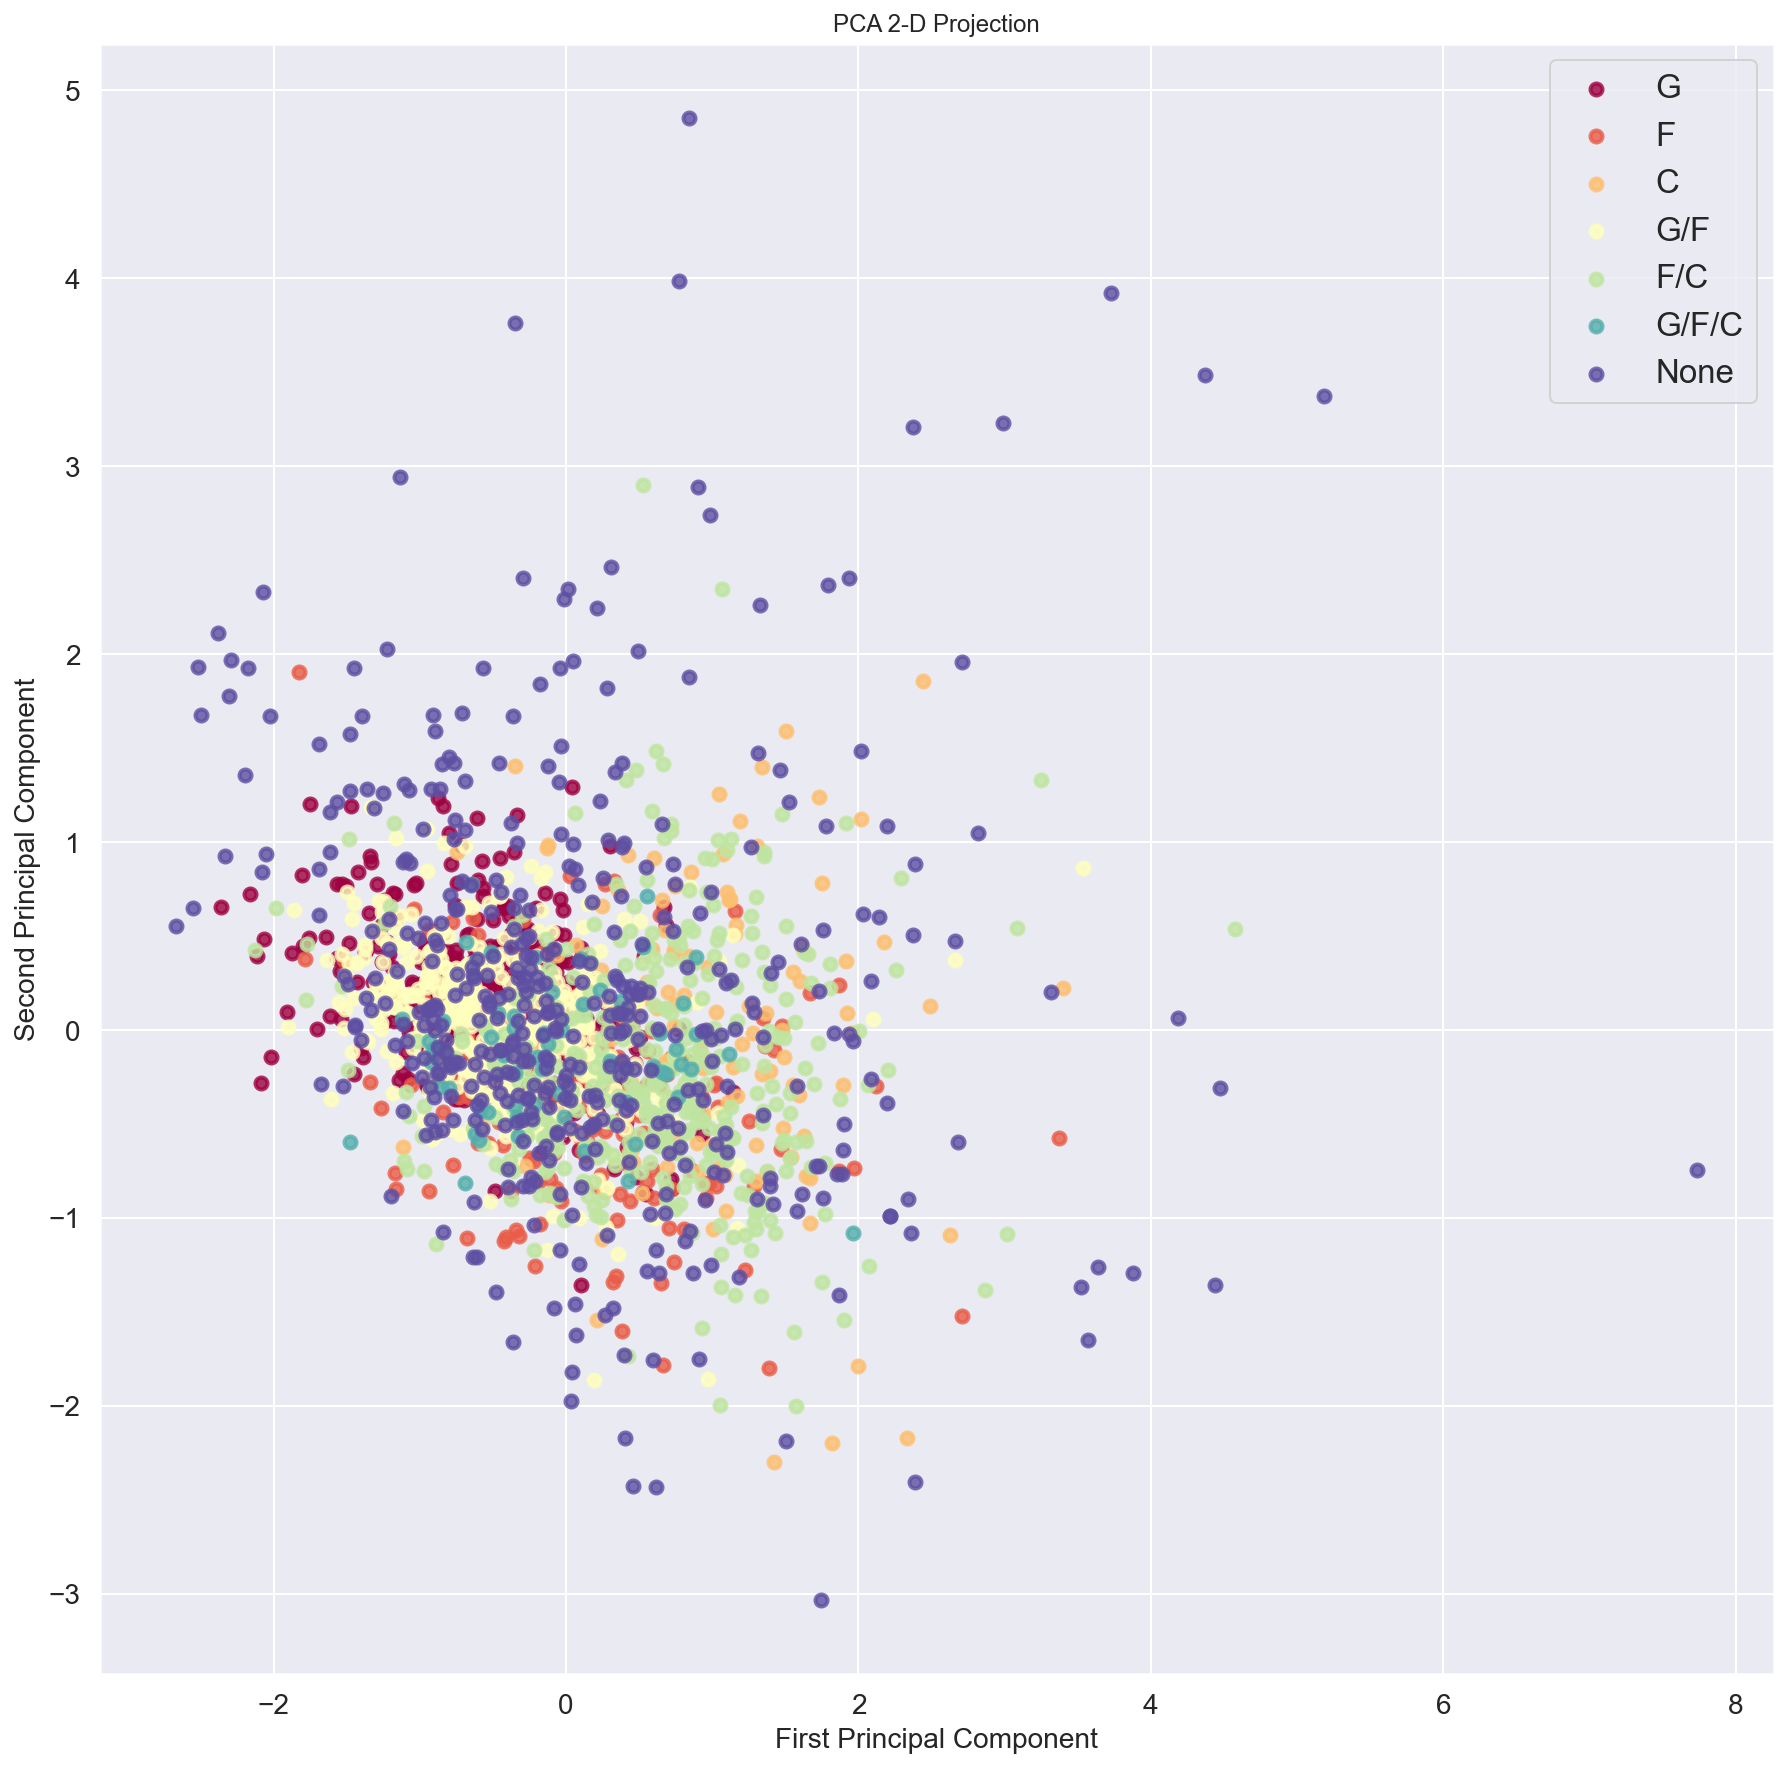

In [12]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_pca_2d_projection(pca, X_pca, dict_encoded, 
                       biplot=False,  
                       feature_labels=X_pca.columns.to_list(),
                       text_fontsize=14,
                       ax=ax)
ax.legend(list(number_position_dict.values()))
plt.show()

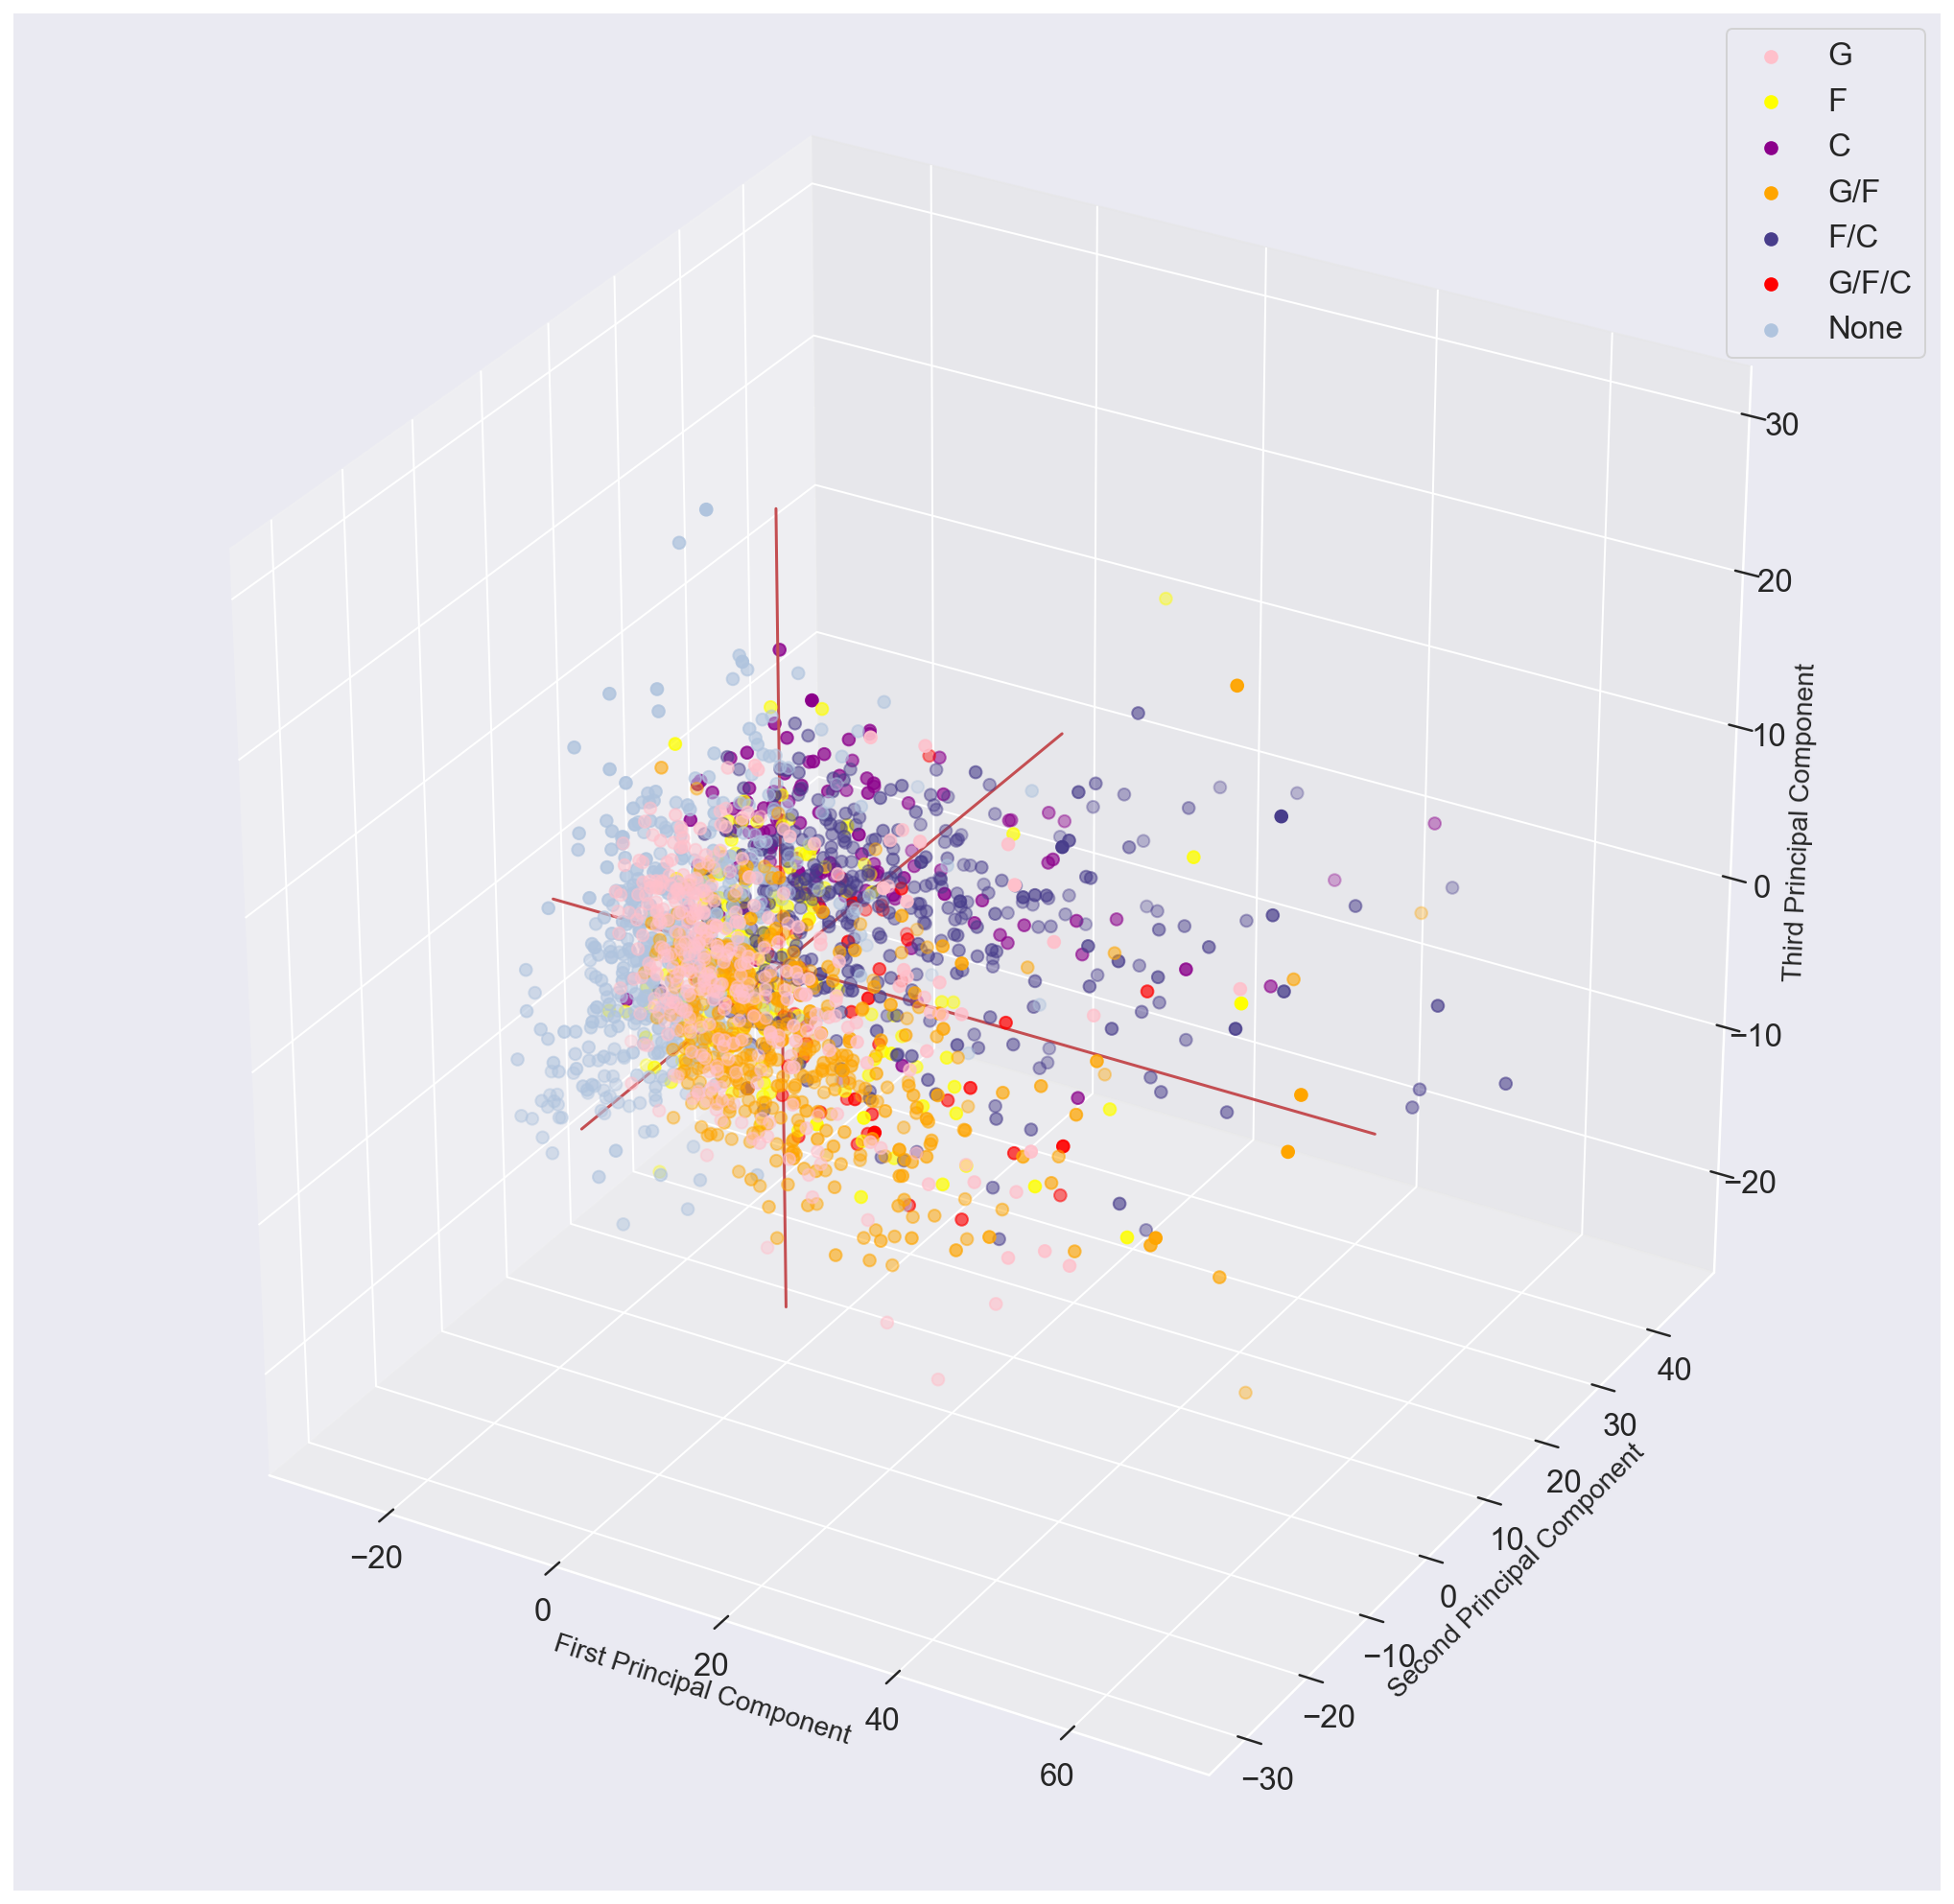

In [13]:
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

ex_variance=np.var(X_pca,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
ex_variance_ratio

y = dict_encoded

Xax = X_pca['PC_1']
Yax = X_pca['PC_2']
Zax = X_pca['PC_3']

cdict = {0:'pink',1:'yellow', 2:'darkmagenta', 3:'orange', 4:'darkslateblue', 5:'red',6:'lightsteelblue'}
labl = number_position_dict
marker = {0:'*',1:'o'}
alpha = {0:.3, 1:.5}

fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(111, projection='3d')

fig.patch.set_facecolor('white')
for l in np.unique(y):
    ix=np.where(y==l)
    ax.scatter(Xax[y==l], Yax[y==l], Zax[y==l], c=cdict[l], s=40,
           label=labl[l])#, marker=marker[l], alpha=alpha[l])

xAxisLine = ((min(X_pca['PC_1']), max(X_pca['PC_1'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(X_pca['PC_2']), max(X_pca['PC_2'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(X_pca['PC_3']), max(X_pca['PC_3'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

ax.set_xlabel("First Principal Component", fontsize=14)
ax.set_ylabel("Second Principal Component", fontsize=14)
ax.set_zlabel("Third Principal Component", fontsize=14)

# # make the panes transparent
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# # make the grid lines transparent
# ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
# ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
# ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

ax.legend()
plt.show()

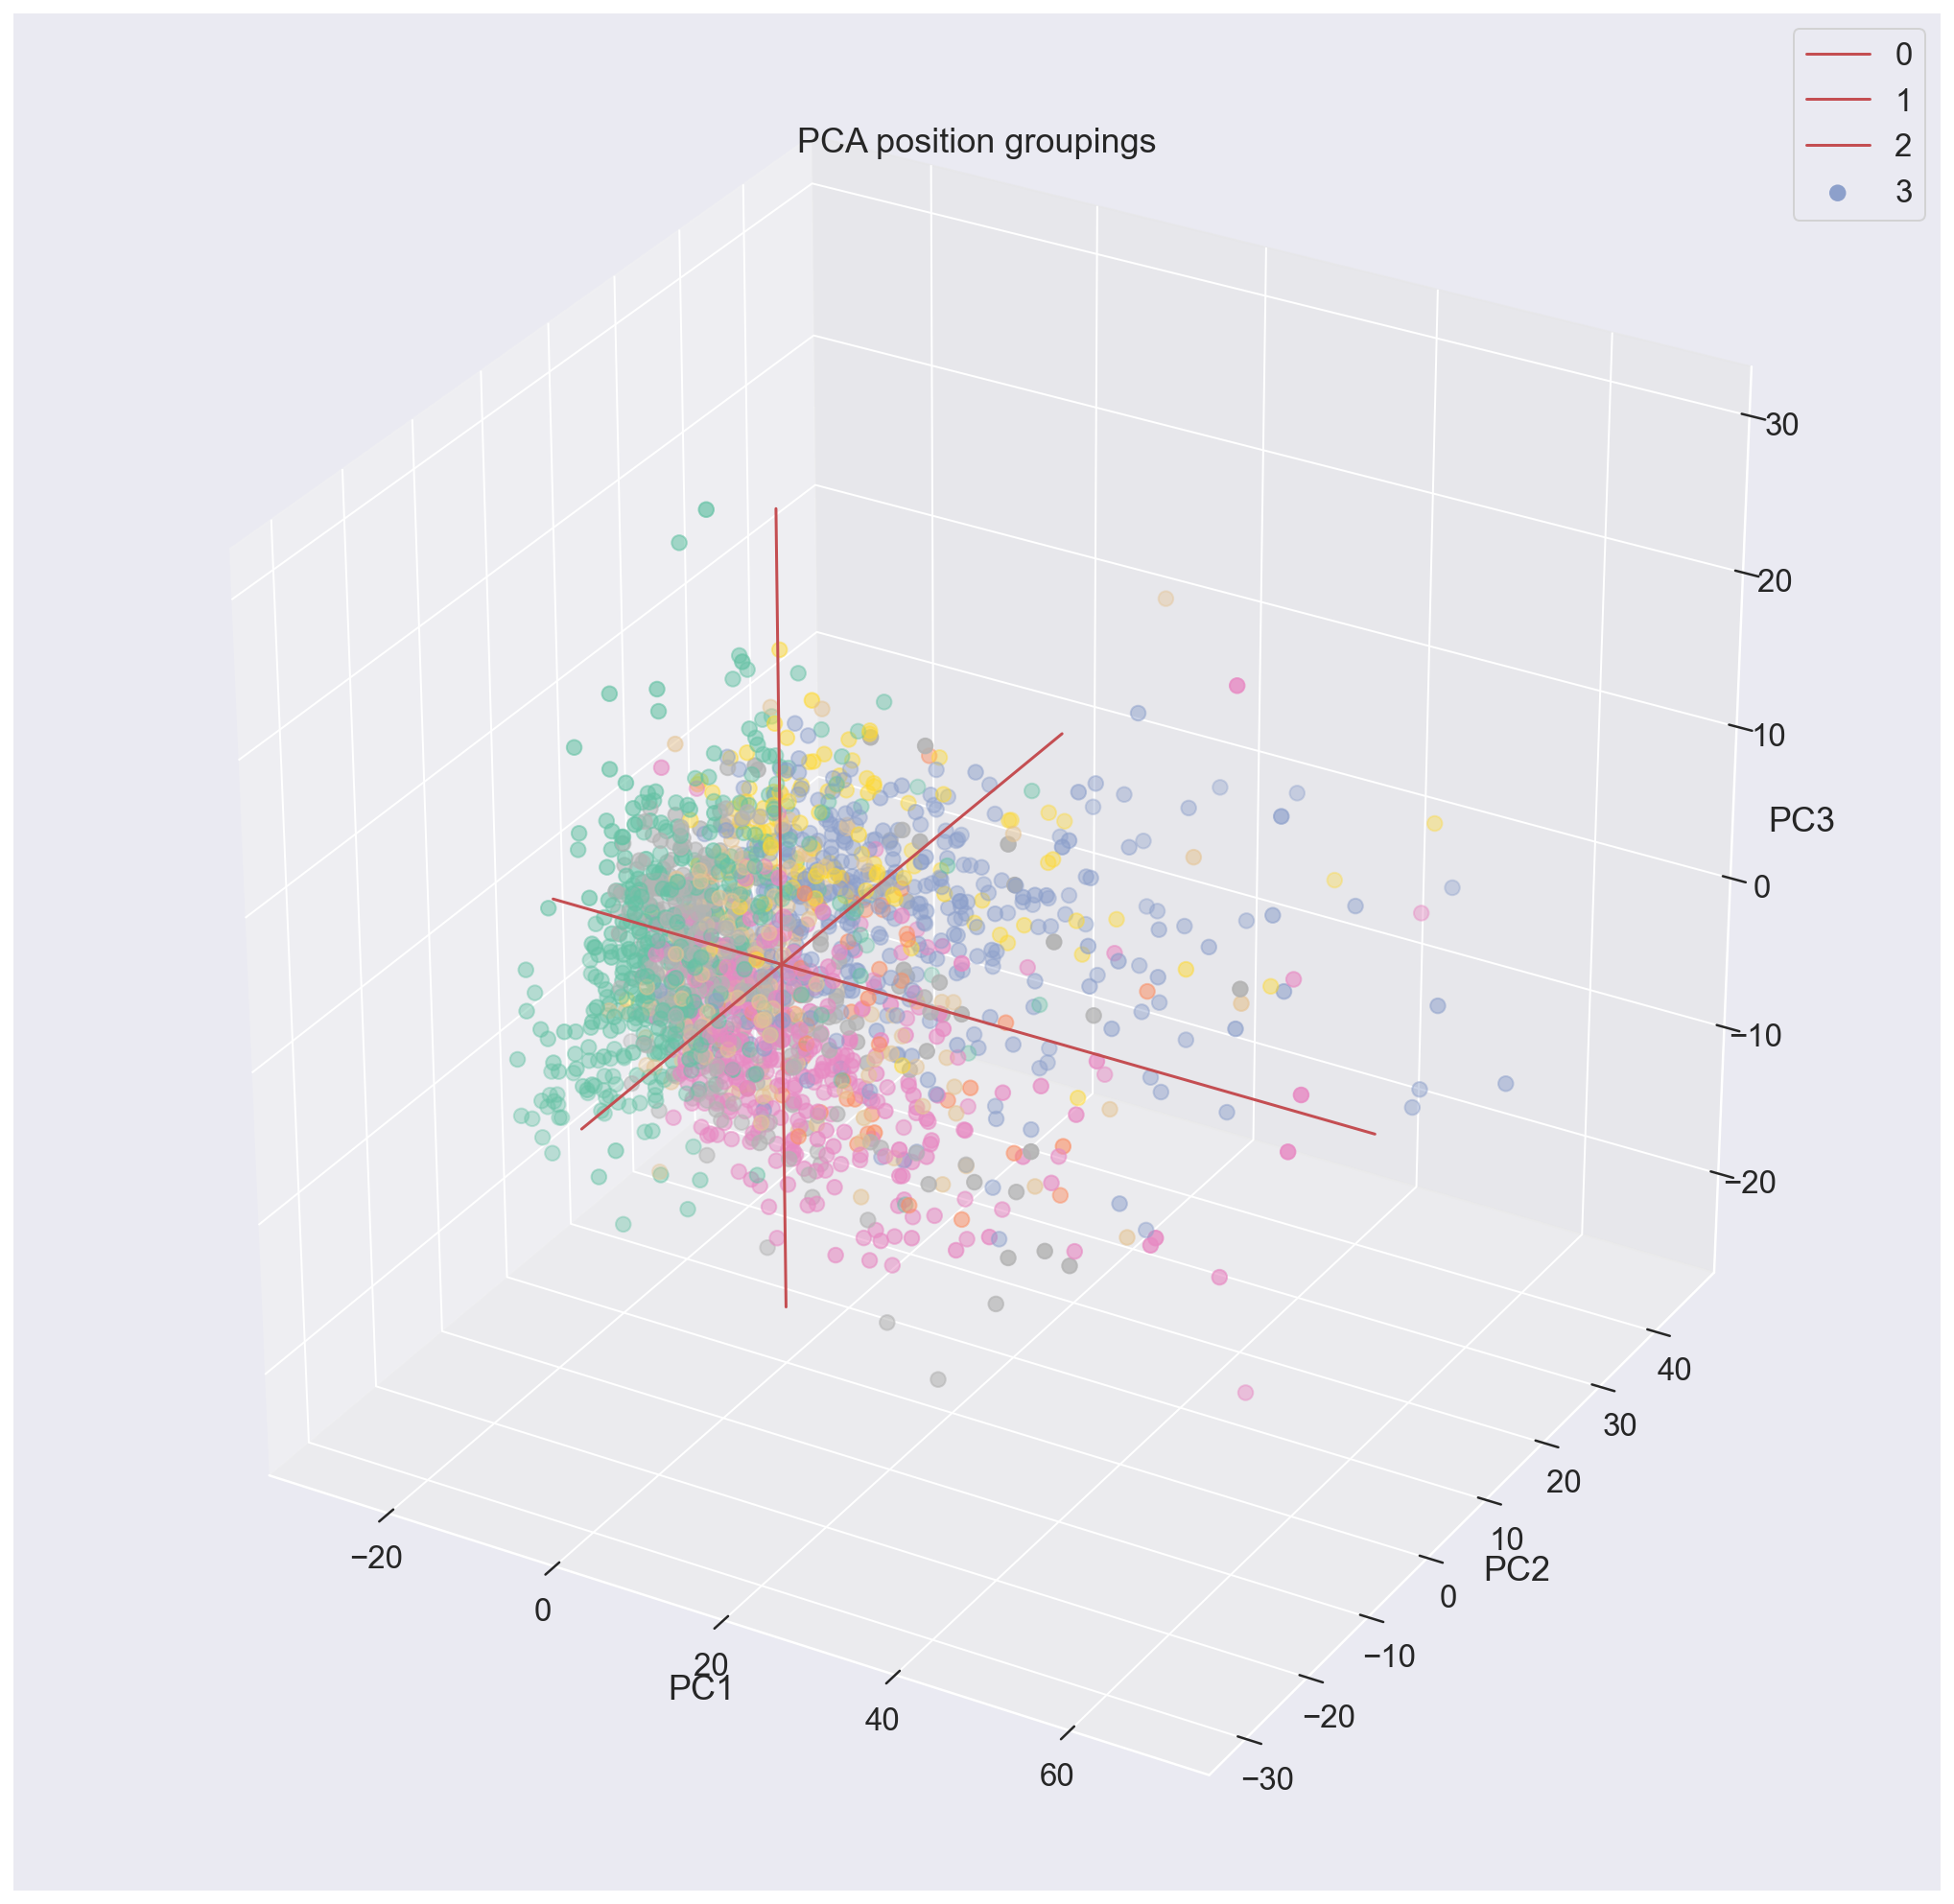

In [14]:
# Plot initialisation
fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca['PC_1'], X_pca['PC_2'], X_pca['PC_3'], c=X_pca.index.map(
    lambda x: position_dict[x[0]]).fillna('None').map(position_number_dict),
           cmap="Set2_r", s=60)
# ax.legend(list(position_number_dict.keys())) 
# make simple, bare axis lines through space:
xAxisLine = ((min(X_pca['PC_1']), max(X_pca['PC_1'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(X_pca['PC_2']), max(X_pca['PC_2'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(X_pca['PC_3']), max(X_pca['PC_3'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA position groupings")
ax.legend(list(position_number_dict.values()))

plt.show()


For n_clusters = 4 the average silhouette_score is: 0.15979567124114882


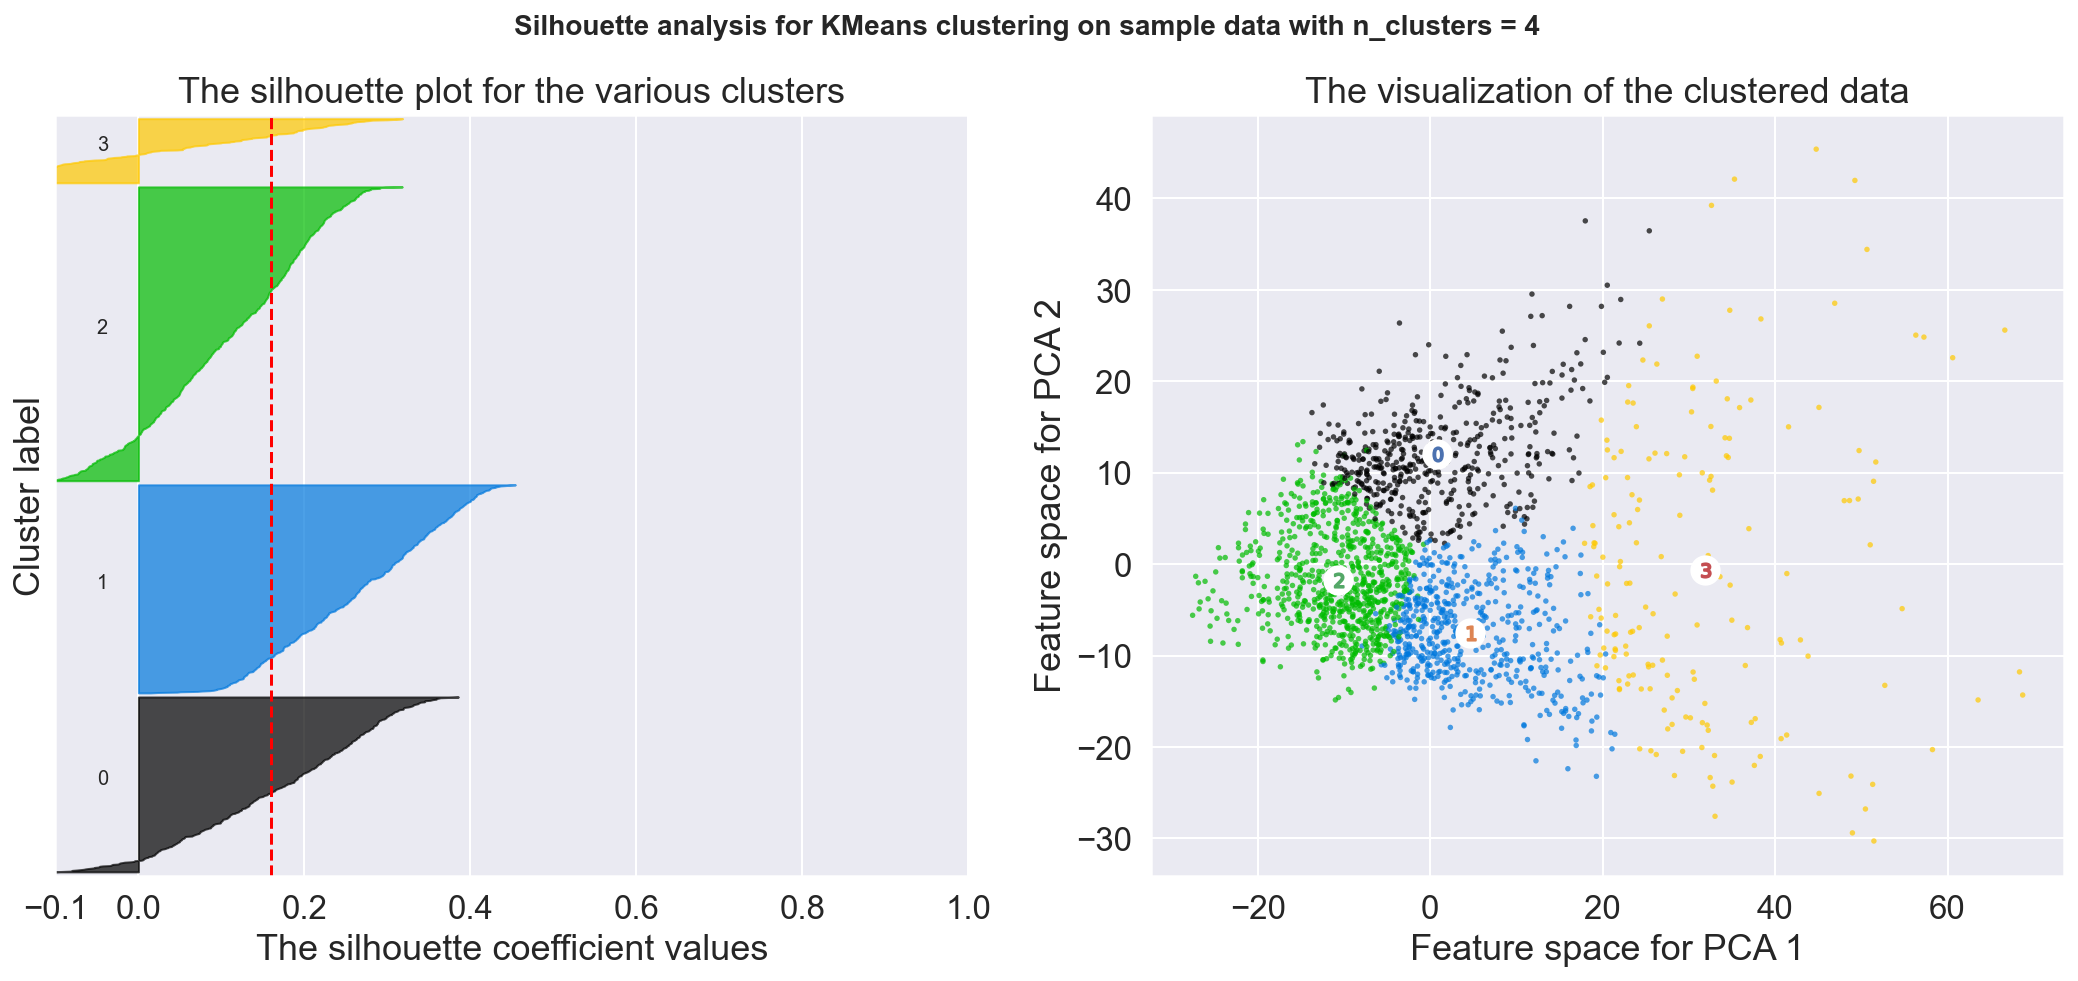

For n_clusters = 5 the average silhouette_score is: 0.16252943688610683


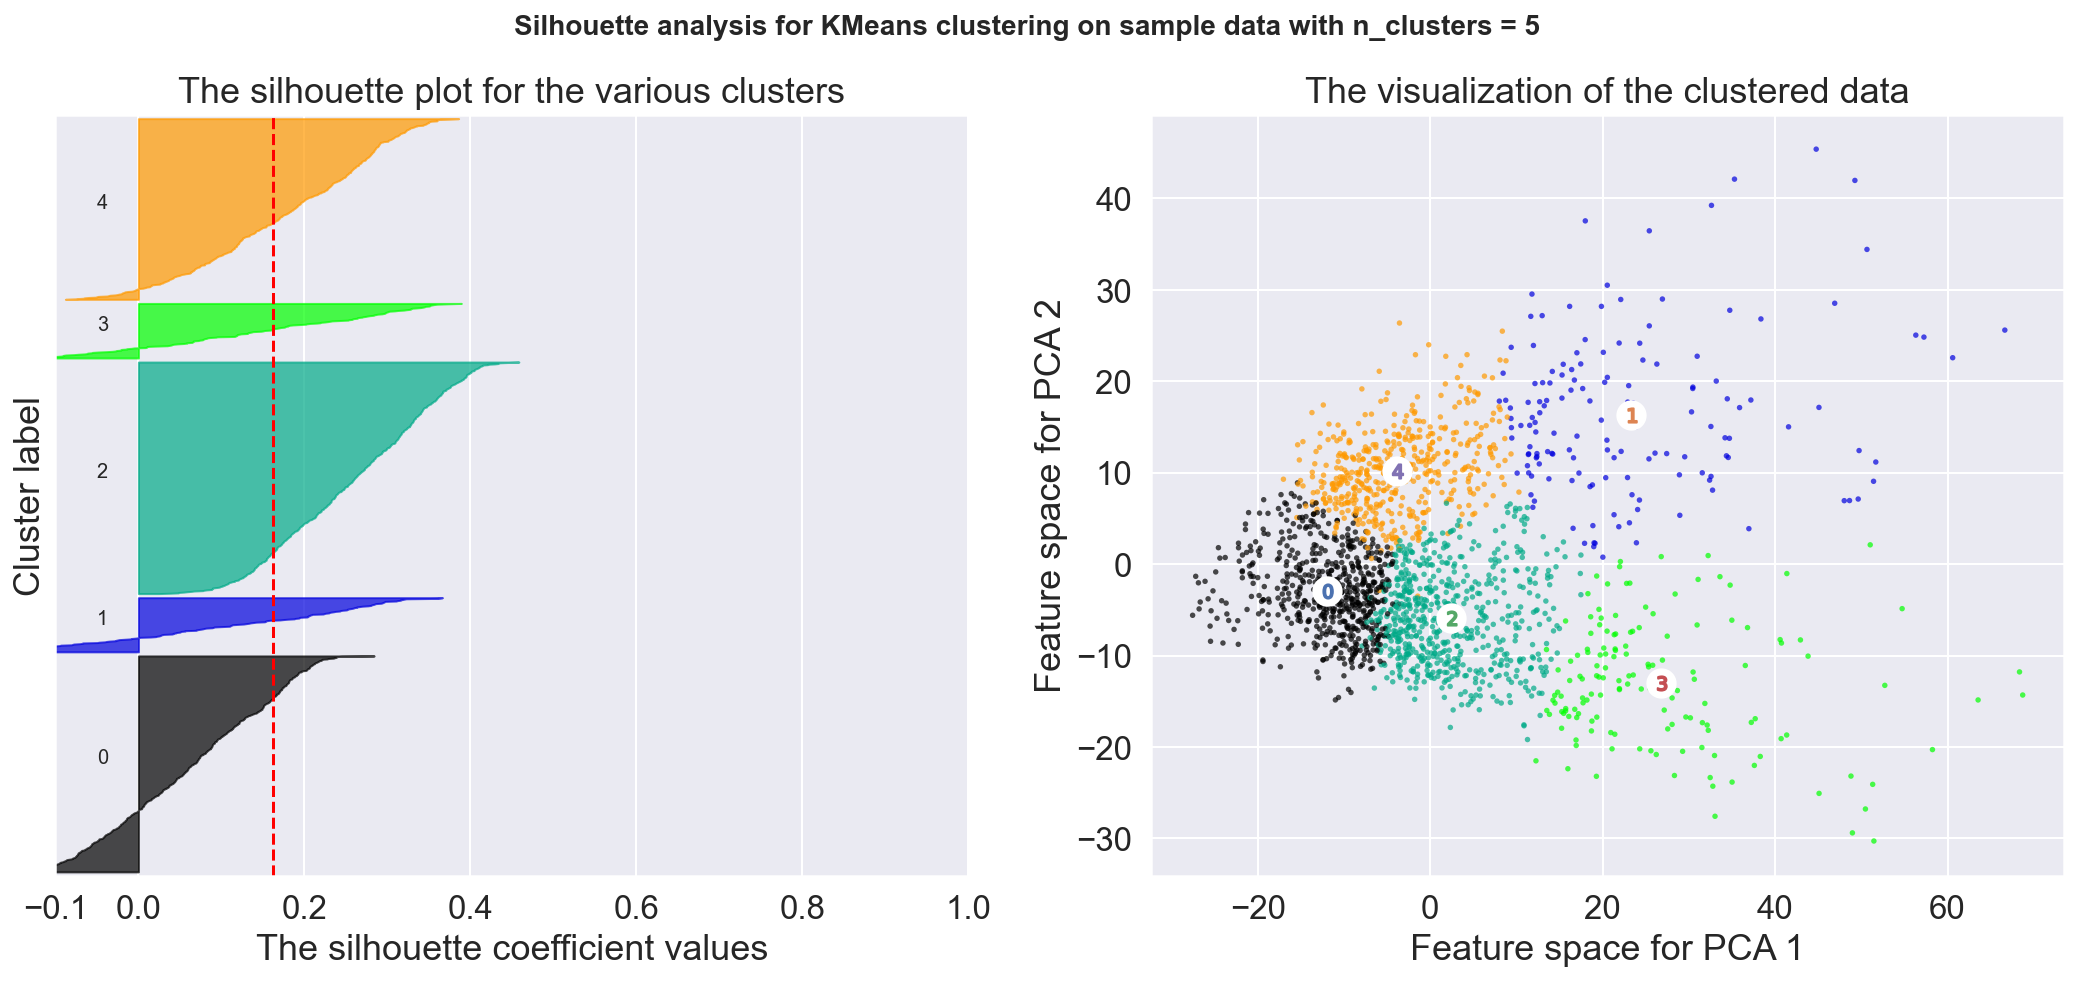

For n_clusters = 6 the average silhouette_score is: 0.17137413370989096


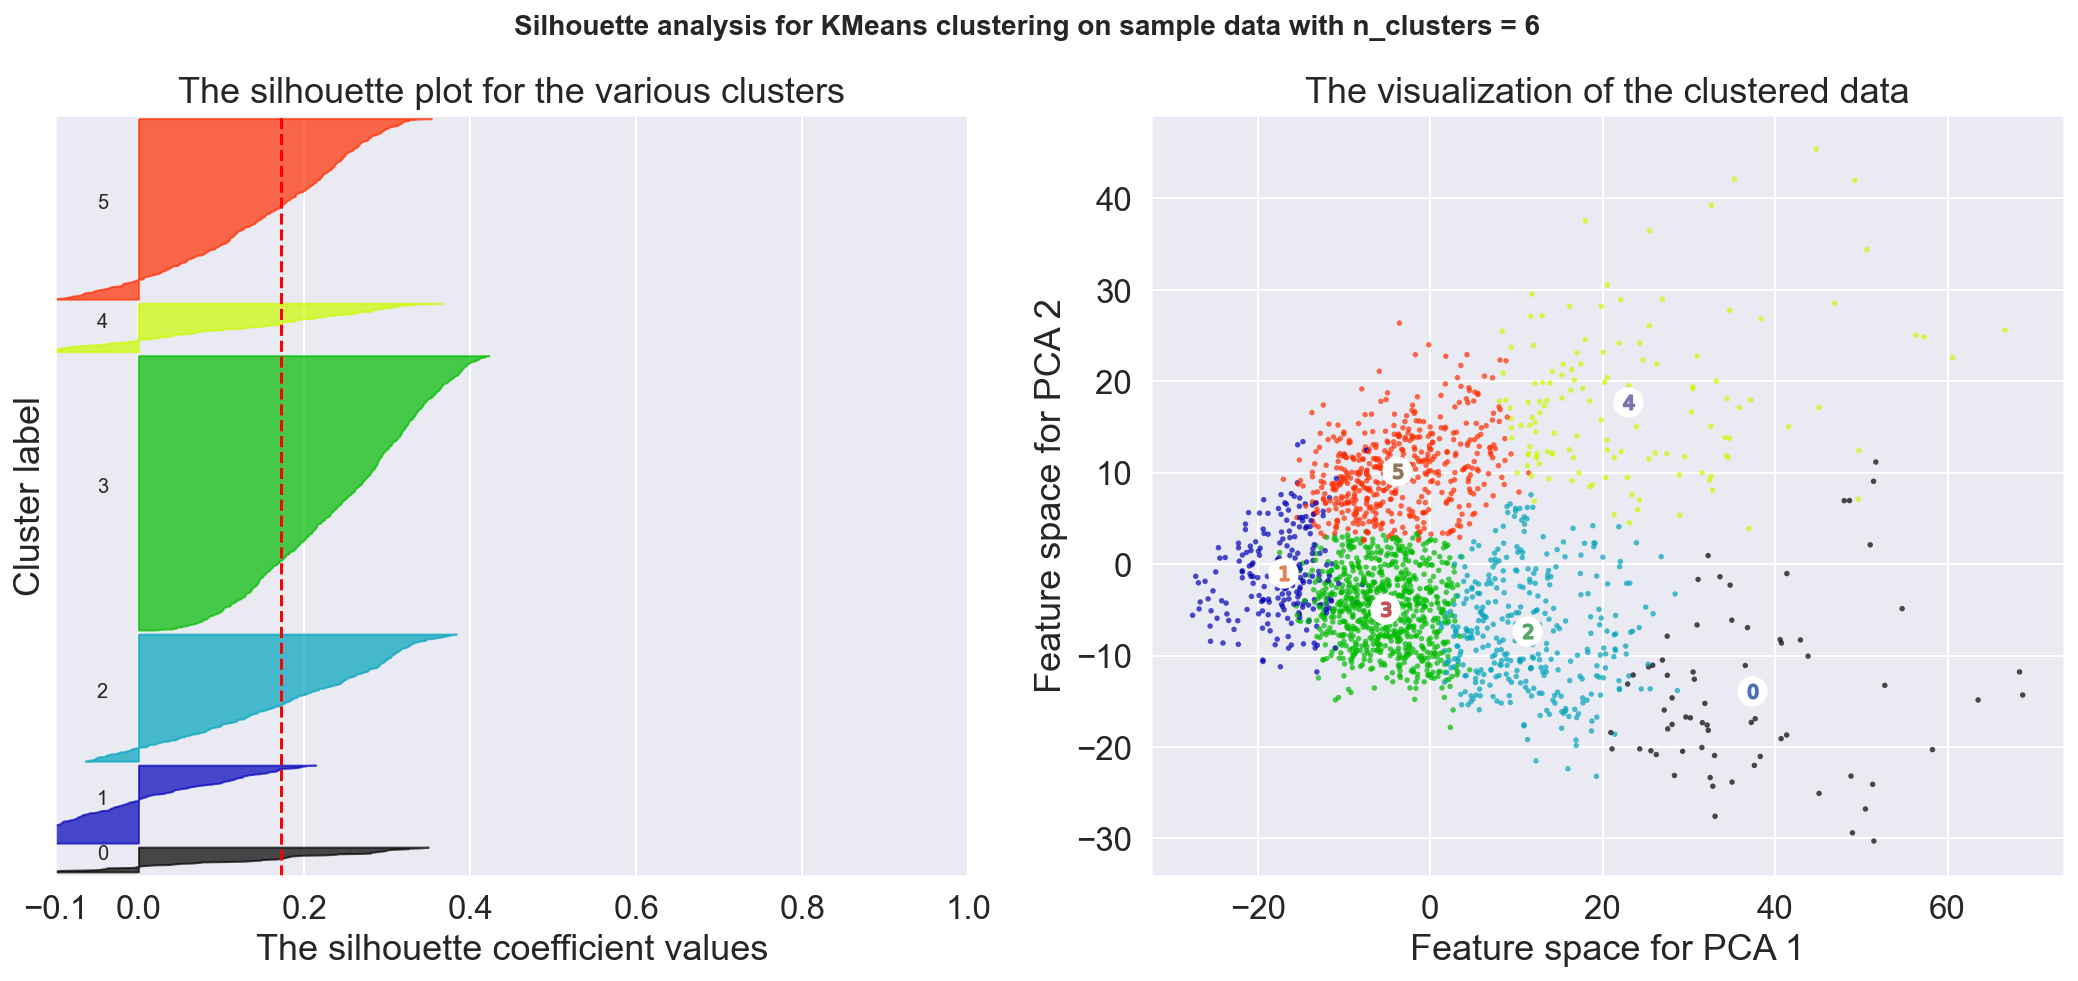

For n_clusters = 7 the average silhouette_score is: 0.16554741466715758


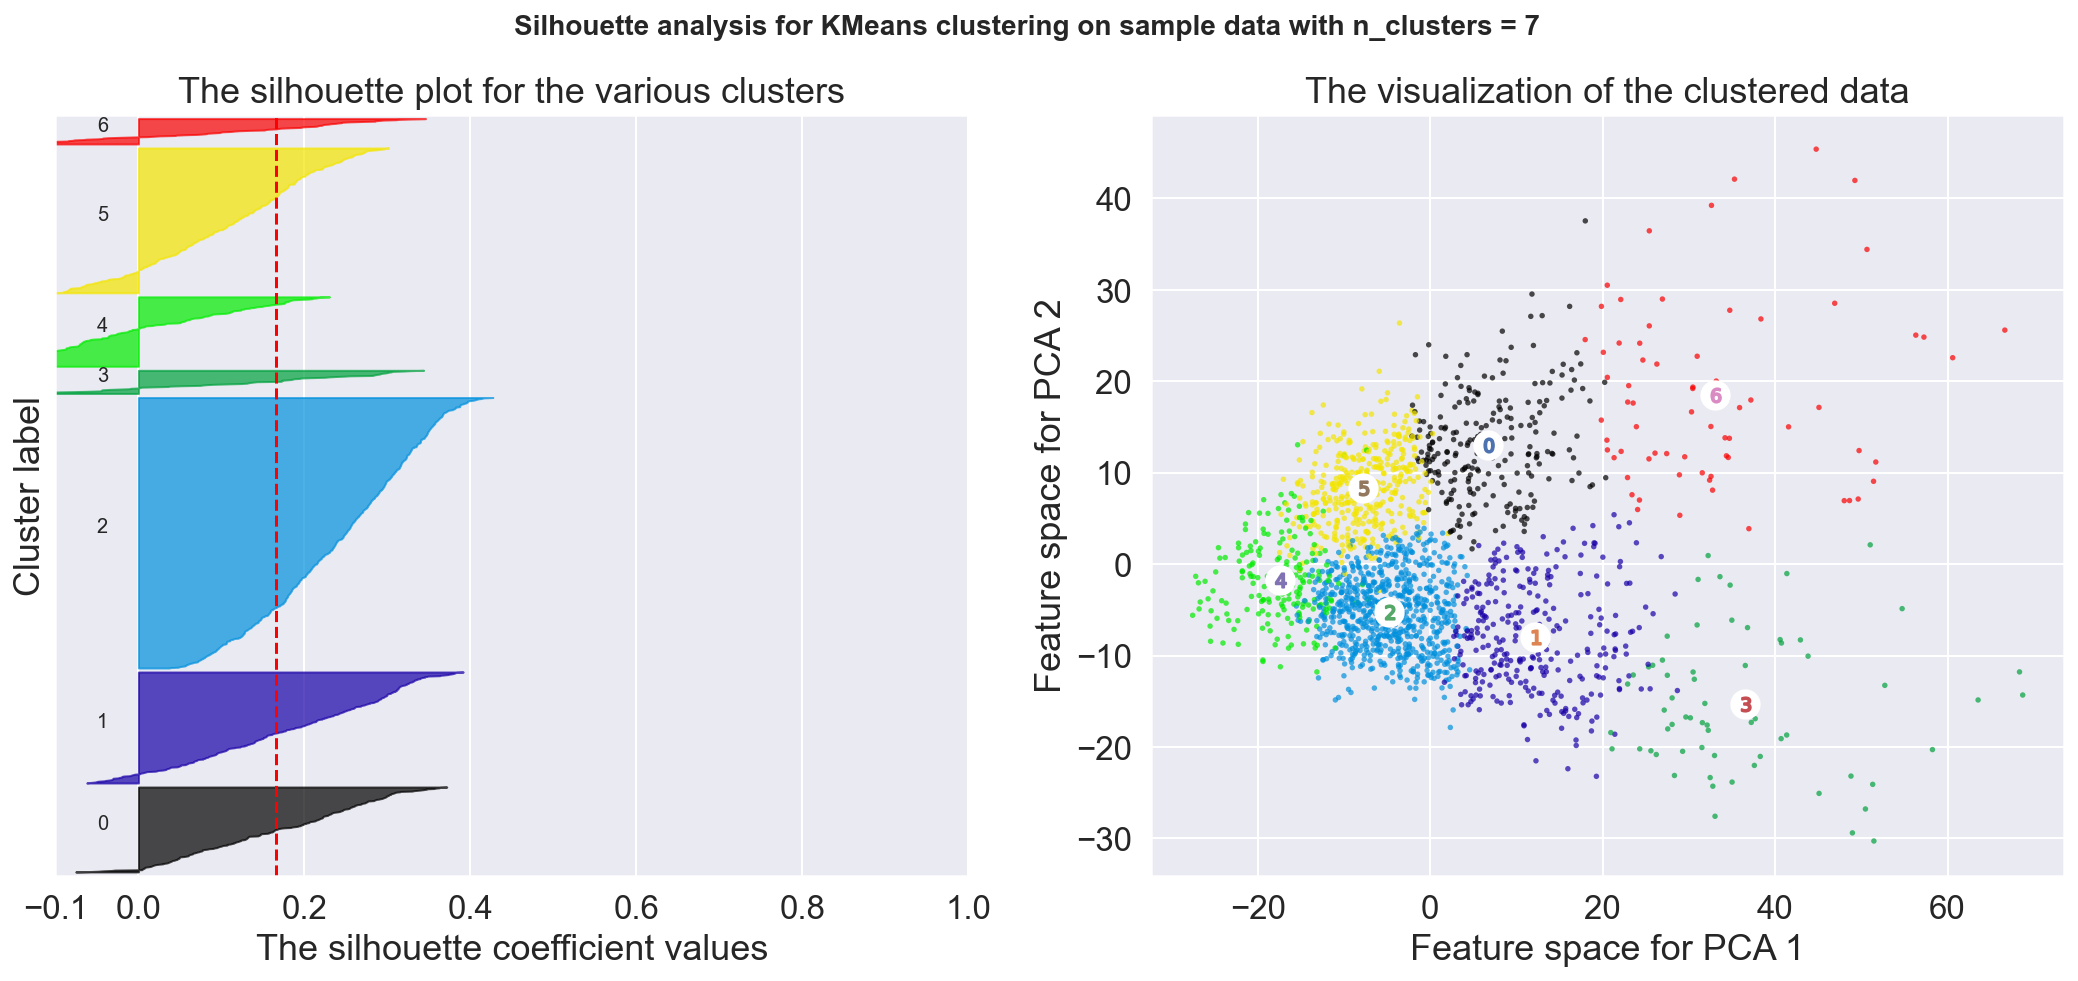

For n_clusters = 8 the average silhouette_score is: 0.1386703487603996


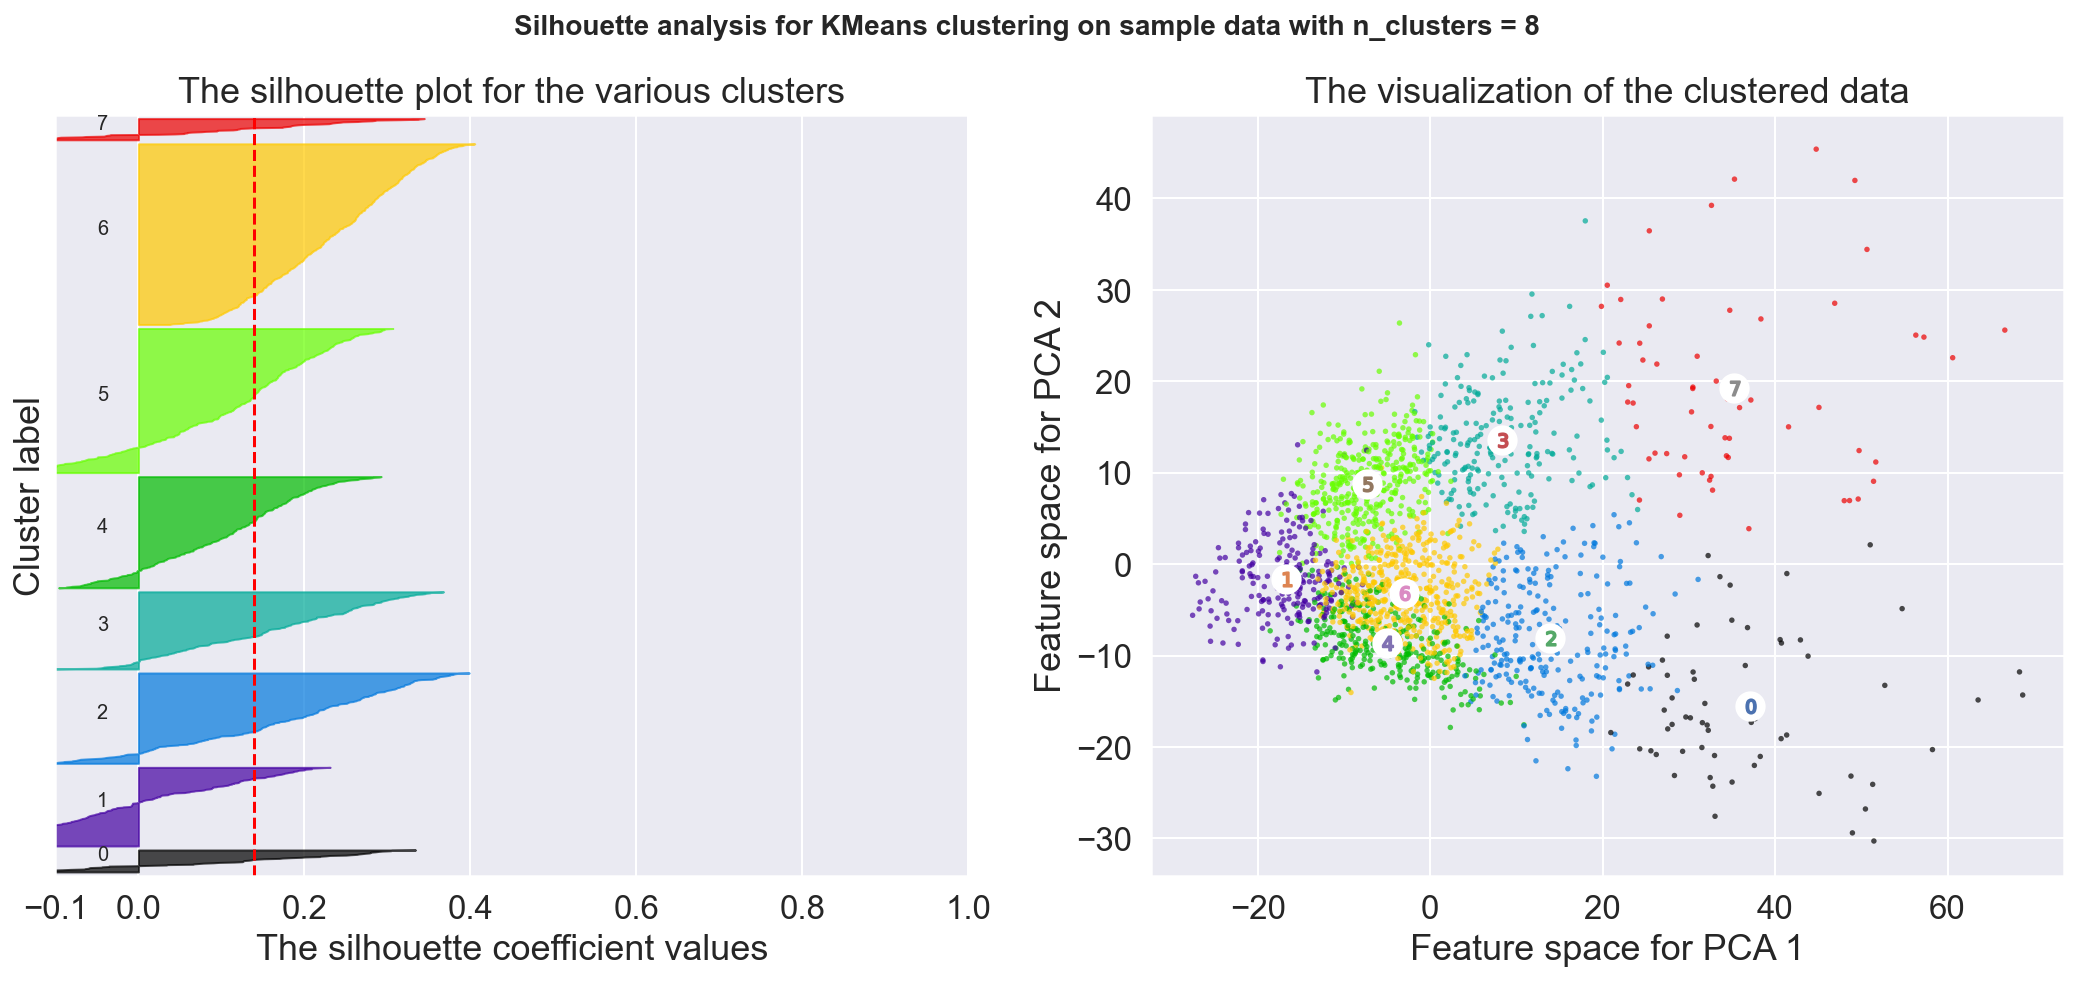

In [15]:
range_n_clusters = [4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    cluster_labels = clusterer.fit_predict(X_pca)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print("For n_clusters =", n_clusters,
          "the average silhouette_score is:", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()
    

#         X.sort_values(by='pts',ascending=False)[['Cluster_labels']]



        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_pca['PC_1'], X_pca['PC_2'], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data")
    ax2.set_xlabel("Feature space for PCA 1")
    ax2.set_ylabel("Feature space for PCA 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

    X['Cluster_labels'] = cluster_labels
    grouped = X.groupby('Cluster_labels')
    groups = list(grouped.groups.keys())
#     for j in groups:
        
#         disp = grouped.get_group(j).sort_values('games_played')
#         disp['position'] = disp.index.map(lambda x: position_dict[x[0]]).fillna('None')
#         print(f'CLUSTER GROUP : {j}', disp['position'].unique(),
#               '\nHeight mean & std :', round(disp['height'].mean(),2), round(disp['height'].std(),2),
#               '\nSecond mean & std :', round(disp['seconds'].mean(),2), round(disp['seconds'].std(),2),
#               '\ngPlayd mean & std :', round(disp['games_played'].mean(),2), round(disp['games_played'].std(),2))
#         display(disp.loc[:,'plus_minus':].tail(20))
        

For n_clusters = 6 the average silhouette_score is: 0.17137413370989096


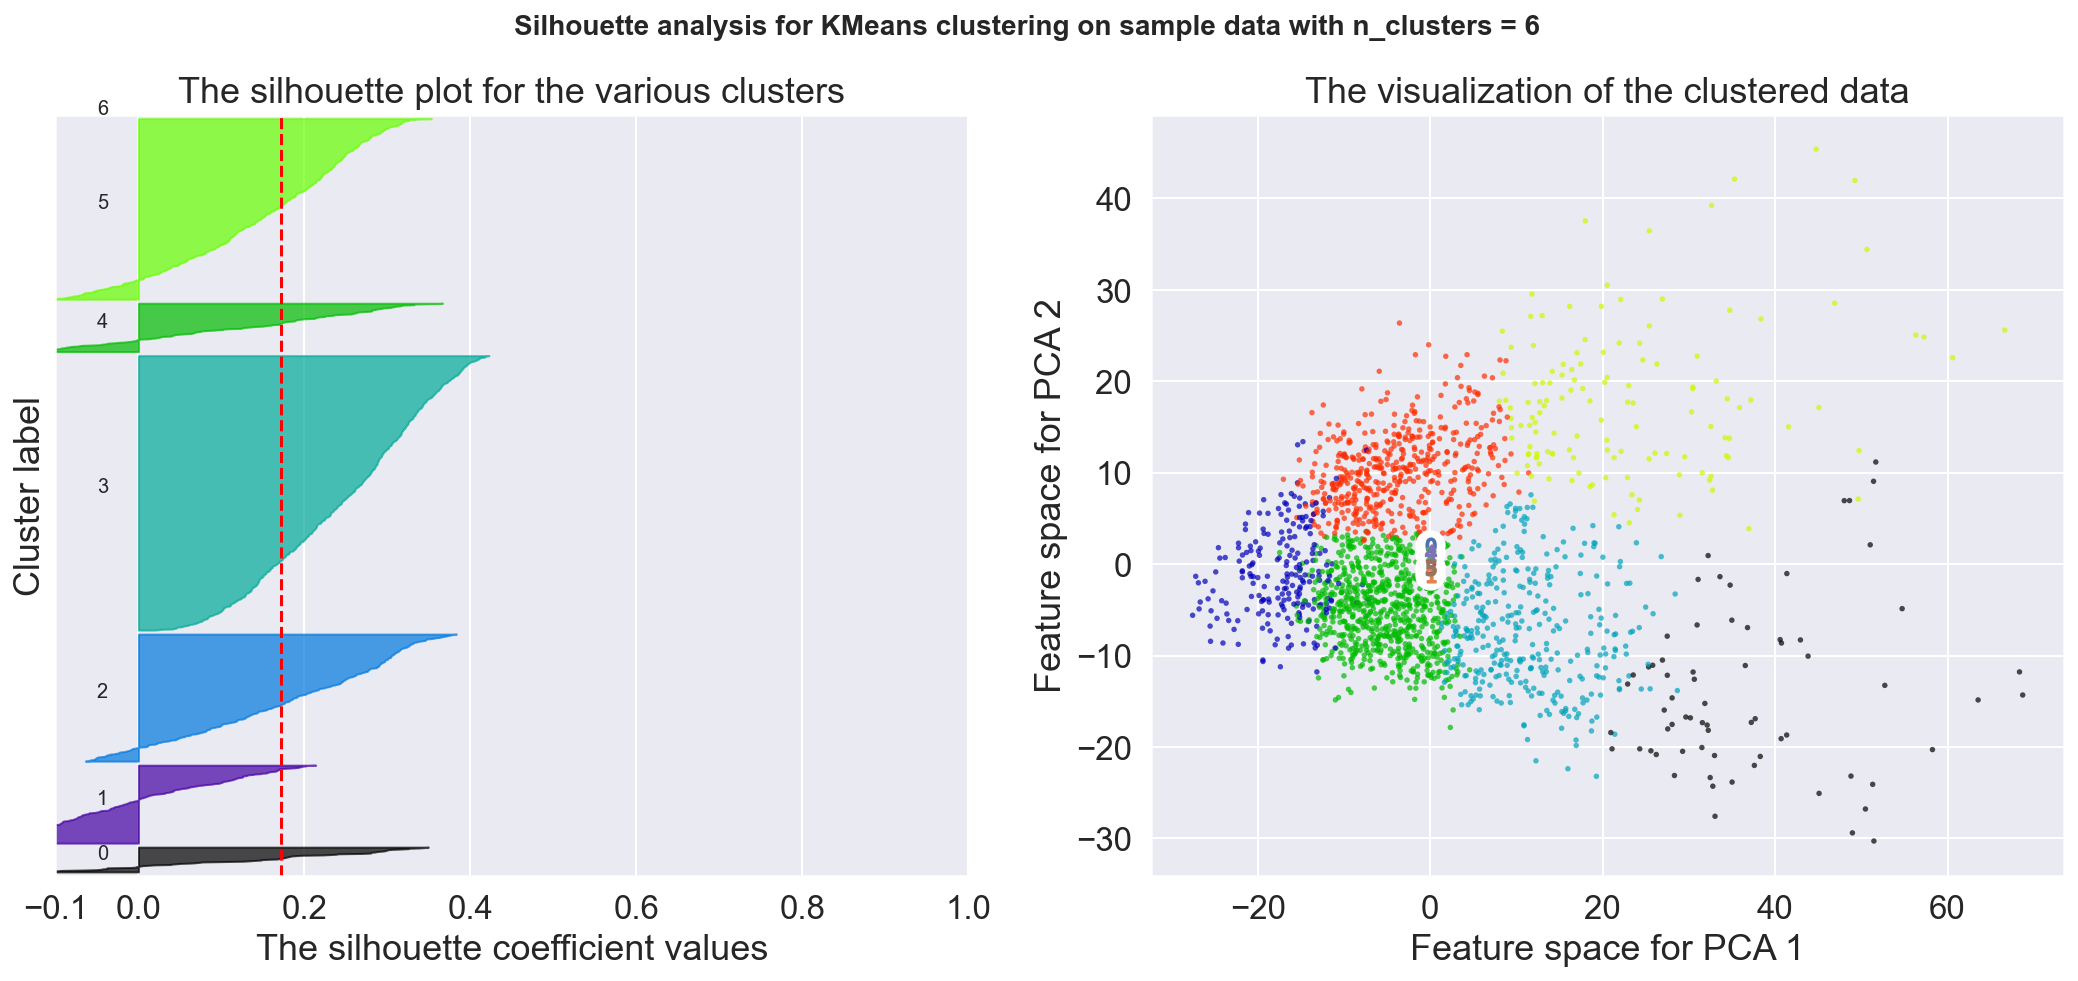

CLUSTER GROUP : 0 ['G' 'G/F' 'F' 'F/C' 'G/F/C'] 
Height mean & std :  1.94 0.08 
Second mean & std :  2031.51 162.65 
gPlayd mean & std :  683.62 342.42 
Number of players :  68


gs   efg_pct    ts_pct  Cluster_labels  \
player_id name                                                            
1629630   Ja Morant       13.949254  0.509072  0.593674               0   
1629029   Luka Doncic     19.328261  0.517329  0.616825               0   
1629027   Trae Young      17.412057  0.499601  0.611792               0   
893       Michael Jordan  14.104255  0.436421  0.503577               0   
1628366   Lonzo Ball      10.077778  0.481254  0.496600               0   
...                             ...       ...       ...             ...   
2548      Dwyane Wade     16.551626  0.494705  0.600263               0   
977       Kobe Bryant     18.923600  0.482737  0.590799               0   
1889      Andre Miller    11.165118  0.467639  0.571882               0   
1718      Paul Pierce     13.980685  0.498068  0.617694               0   
2544      LeBron James    22.463738  0.540174  0.634185               0   

                         position  
player_id name                     
1629630   Ja Morant             G  
1629029   Luka Doncic         G/F  
1629027   Trae Young            G  
893       Michael Jordan      G/F  
1628366   Lonzo Ball          G/F  
...                           ...  
2548      Dwyane Wade         G/F  
977       Kobe Bryant         G/F  
1889      Andre Miller          G  
1718      Paul Pierce         G/F  
2544      LeBron James        G/F  

[68 rows x 5 columns]

CLUSTER GROUP : 1 ['None' 'F' 'G' 'C' 'F/C' 'G/F'] 
Height mean & std :  2.0 0.08 
Second mean & std :  639.8 215.98 
gPlayd mean & std :  8.35 12.42 
Number of players :  212


gs   efg_pct    ts_pct  Cluster_labels  \
player_id name                                                              
1629760   Matt Mooney        0.200000  0.000000  0.000000               1   
1619      Kiwane Garris     -0.800000  0.222222  0.222222               1   
1746      DeMarco Johnson    0.900000  0.000000  0.000000               1   
1628500   Ben Moore         -0.500000       NaN       NaN               1   
1628475   Matt Williams Jr. -0.800000  0.250000  0.250000               1   
...                               ...       ...       ...             ...   
2220      Brandon Armstrong  1.028302  0.369565  0.382904               1   
2415      Ryan Humphrey      1.478689  0.333333  0.402999               1   
203923    James Young        2.054839  0.454545  0.488395               1   
203962    Josh Huestis       1.914286  0.424623  0.428795               1   
2061      Dan Langhi         2.252874  0.412437  0.438510               1   

                            position  
player_id name                        
1629760   Matt Mooney           None  
1619      Kiwane Garris         None  
1746      DeMarco Johnson       None  
1628500   Ben Moore             None  
1628475   Matt Williams Jr.     None  
...                              ...  
2220      Brandon Armstrong     None  
2415      Ryan Humphrey            G  
203923    James Young           None  
203962    Josh Huestis             G  
2061      Dan Langhi               F  

[212 rows x 5 columns]

CLUSTER GROUP : 2 ['None' 'G' 'F' 'C' 'F/C' 'G/F' 'G/F/C'] 
Height mean & std :  1.96 0.07 
Second mean & std :  1634.25 222.77 
gPlayd mean & std :  494.52 332.07 
Number of players :  345


gs   efg_pct    ts_pct  Cluster_labels  \
player_id name                                                                 
201182    Derrick Byars         8.400000  0.222222  0.404858               2   
204054    Zoran Dragic         14.200000  0.617647  0.630734               2   
1628504   Xavier Rathan-Mayes   1.280000  0.297619  0.329695               2   
1628539   Mychal Mulder         6.100000  0.507463  0.552843               2   
1627215   Walt Lemon Jr.        8.222222  0.459596  0.494710               2   
...                                  ...       ...       ...             ...   
2037      Jamal Crawford        9.584006  0.475568  0.555855               2   
2207      Joe Johnson          11.081353  0.495479  0.550379               2   
2225      Tony Parker          11.656478  0.502374  0.572725               2   
1891      Jason Terry           9.880921  0.516972  0.579206               2   
1713      Vince Carter         11.738648  0.488551  0.567321               2   

                              position  
player_id name                          
201182    Derrick Byars           None  
204054    Zoran Dragic               G  
1628504   Xavier Rathan-Mayes     None  
1628539   Mychal Mulder              G  
1627215   Walt Lemon Jr.             G  
...                                ...  
2037      Jamal Crawford           G/F  
2207      Joe Johnson              G/F  
2225      Tony Parker                G  
1891      Jason Terry                G  
1713      Vince Carter             G/F  

[345 rows x 5 columns]

CLUSTER GROUP : 3 ['None' 'F' 'G' 'F/C' 'G/F' 'C' 'G/F/C'] 
Height mean & std :  1.96 0.08 
Second mean & std :  1029.59 235.58 
gPlayd mean & std :  163.2 191.7 
Number of players :  744


gs   efg_pct    ts_pct  Cluster_labels  \
player_id name                                                             
1628935   Aaron Jackson     2.300000  0.388889  0.423729               3   
1754      Andrae Patterson  1.300000  1.000000  1.000000               3   
203317    Tim Ohlbrecht     2.300000  0.500000  0.675676               3   
201802    Oliver Lafayette  6.000000  0.583333  0.583333               3   
2657      Yuta Tabuse       4.600000  0.500000  0.902062               3   
...                              ...       ...       ...             ...   
201158    Marco Belinelli   6.474887  0.511653  0.575630               3   
1477      Bruce Bowen       4.511547  0.503235  0.535603               3   
2581      Steve Blake       5.483370  0.502336  0.535969               3   
200757    Thabo Sefolosha   5.451698  0.507248  0.558092               3   
2733      Shaun Livingston  5.562619  0.490635  0.563139               3   

                           position  
player_id name                       
1628935   Aaron Jackson        None  
1754      Andrae Patterson     None  
203317    Tim Ohlbrecht        None  
201802    Oliver Lafayette     None  
2657      Yuta Tabuse          None  
...                             ...  
201158    Marco Belinelli       G/F  
1477      Bruce Bowen           G/F  
2581      Steve Blake             G  
200757    Thabo Sefolosha       G/F  
2733      Shaun Livingston      G/F  

[744 rows x 5 columns]

CLUSTER GROUP : 4 ['None' 'G/F' 'F' 'F/C' 'C' 'G/F/C'] 
Height mean & std :  2.09 0.05 
Second mean & std :  1702.18 253.72 
gPlayd mean & std :  594.84 358.1 
Number of players :  132


gs   efg_pct    ts_pct  Cluster_labels  \
player_id name                                                            
201286    Eric Dawson      5.700000  0.500000  0.533175               4   
1629045   Bonzie Colson   14.750000  0.411765  0.500278               4   
2569      Ndudi Ebi        9.450000  0.523810  0.587467               4   
1629203   Jemerrio Jones   8.140000  0.406250  0.416153               4   
23        Dennis Rodman    5.258333  0.387097  0.498826               4   
...                             ...       ...       ...             ...   
1890      Shawn Marion    13.177057  0.508346  0.562240               4   
708       Kevin Garnett   16.110353  0.501624  0.583643               4   
2200      Pau Gasol       14.724062  0.512899  0.609761               4   
1495      Tim Duncan      16.433647  0.503195  0.595125               4   
1717      Dirk Nowitzki   16.249599  0.511147  0.620081               4   

                         position  
player_id name                     
201286    Eric Dawson        None  
1629045   Bonzie Colson       G/F  
2569      Ndudi Ebi          None  
1629203   Jemerrio Jones        F  
23        Dennis Rodman         F  
...                           ...  
1890      Shawn Marion        G/F  
708       Kevin Garnett       F/C  
2200      Pau Gasol           F/C  
1495      Tim Duncan          F/C  
1717      Dirk Nowitzki       F/C  

[132 rows x 5 columns]

CLUSTER GROUP : 5 ['None' 'F' 'C' 'G/F' 'G' 'F/C' 'G/F/C'] 
Height mean & std :  2.08 0.05 
Second mean & std :  959.04 252.15 
gPlayd mean & std :  195.7 220.61 
Number of players :  490


gs   efg_pct    ts_pct  Cluster_labels  \
player_id name                                                           
1629044   Shamorie Ponds  3.600000  0.666667  0.666667               5   
2237      Ratko Varda     1.800000  0.666667  0.776398               5   
1629734   Kyle Alexander  1.300000  1.000000  1.000000               5   
1628450   Eric Mika       5.600000  0.666667  0.872093               5   
1628451   Jacob Wiley     5.200000  0.500000  0.581395               5   
...                            ...       ...       ...             ...   
101161    Amir Johnson    6.879680  0.584375  0.641340               5   
1737      Nazr Mohammed   5.341593  0.492079  0.557135               5   
2617      Udonis Haslem   6.518730  0.489926  0.567356               5   
2555      Nick Collison   5.465696  0.538896  0.607975               5   
2585      Zaza Pachulia   6.132238  0.469867  0.599138               5   

                         position  
player_id name                     
1629044   Shamorie Ponds     None  
2237      Ratko Varda        None  
1629734   Kyle Alexander     None  
1628450   Eric Mika          None  
1628451   Jacob Wiley        None  
...                           ...  
101161    Amir Johnson        F/C  
1737      Nazr Mohammed       F/C  
2617      Udonis Haslem       F/C  
2555      Nick Collison       F/C  
2585      Zaza Pachulia       F/C  

[490 rows x 5 columns]

In [16]:
"""For n_clusters = 6 the average silhouette_score is: 0.17137413370989096"""
# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X_pca) + (6 + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
clusterer = KMeans(n_clusters=6, random_state=1)
cluster_labels = clusterer.fit_predict(X_std)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X_pca, cluster_labels)
print("For n_clusters =", 6,
      "the average silhouette_score is:", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

y_lower = 10
for i in range(7):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()


#         X.sort_values(by='pts',ascending=False)[['Cluster_labels']]



    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhoutte score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / 6)
ax2.scatter(X_pca['PC_1'], X_pca['PC_2'], marker='.', s=30, lw=0, alpha=0.7,
            c=colors)

# Labeling the clusters
centers = clusterer.cluster_centers_

# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1],
            marker='o', c="white", alpha=1, s=200)

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

ax2.set_title("The visualization of the clustered data")
ax2.set_xlabel("Feature space for PCA 1")
ax2.set_ylabel("Feature space for PCA 2")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
              "with n_clusters = %d" % 6),
             fontsize=14, fontweight='bold')

plt.show()

X['Cluster_labels'] = cluster_labels
grouped = X.groupby('Cluster_labels')
groups = list(grouped.groups.keys())
for j in groups:

    disp = grouped.get_group(j).sort_values('games_played')
    disp['position'] = disp.index.map(lambda x: position_dict[x[0]]).fillna('None')
    print(f'CLUSTER GROUP : {j}', disp['position'].unique(),
          '\nHeight mean & std : ', round(disp['height'].mean(),2), round(disp['height'].std(),2),
          '\nSecond mean & std : ', round(disp['seconds'].mean(),2), round(disp['seconds'].std(),2),
          '\ngPlayd mean & std : ', round(disp['games_played'].mean(),2), round(disp['games_played'].std(),2),
          '\nNumber of players : ', disp.shape[0])
    display(disp.loc[:,'gs':])

In [18]:
ex_variance=np.var(X_pca,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
ex_variance_ratio

y = cluster_labels
# X['colors'] = colors

Xax = X_pca['PC_1']
Yax = X_pca['PC_2']
Zax = X_pca['PC_3']

cdict = {0:'yellow',1:'lightsteelblue', 2:'orange', 3:'red', 4:'pink', 5:'darkmagenta',6:'lightsteelblue'}
labl = number_position_dict
marker = {0:'*',1:'o'}
alpha = {0:.3, 1:.5}

fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(111, projection='3d')

fig.patch.set_facecolor('white')
for l in np.unique(y):
    ix=np.where(y==l)
    ax.scatter(Xax[y==l], Yax[y==l], Zax[y==l], c=cdict[l], s=40,
           label=X[y==l]['Cluster_labels'].unique()[0])#, marker=marker[l], alpha=alpha[l])

xAxisLine = ((min(X_pca['PC_1']), max(X_pca['PC_1'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(X_pca['PC_2']), max(X_pca['PC_2'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(X_pca['PC_3']), max(X_pca['PC_3'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

ax.set_xlabel("First Principal Component", fontsize=14)
ax.set_ylabel("Second Principal Component", fontsize=14)
ax.set_zlabel("Third Principal Component", fontsize=14)

# # make the panes transparent
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# # make the grid lines transparent
# ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
# ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
# ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

ax.legend()
plt.show()

SyntaxError: invalid syntax (<ipython-input-18-00073ce06861>, line 28)

In [17]:
import plotly.express as px

fig = px.scatter_3d(X_pca, x='PC_1', y='PC_2', z='PC_3',
              color=X['Cluster_labels'].map({0:'SuperStars', 1:'MinImpact',
                                                           2:'WingStars', 3:'WingRotation',
                                                           4:'BigStars', 5:'BigRotation'}), size=X['height'], size_max=18,
              opacity=0.7)

# import plotly.io as pio

# pio.write_html(fig, file='3d_clustered_players.html', auto_open=True)
# fig.labels()
fig.show()

In [44]:
cluster_dictionary = {i: j for i, j in list(zip(X.index.get_level_values(0),
                                                X['Cluster_labels'].map({0:'SuperStar', 1:'MinImpact',
                                                                         2:'WingStar', 3:'WingRotation',
                                                                         4:'BigStar', 5:'BigRotation'}).values))}

{3: 'BigRotation',
 15: 'WingRotation',
 21: 'WingRotation',
 22: 'BigRotation',
 23: 'BigStar',
 26: 'BigRotation',
 28: 'MinImpact',
 29: 'BigRotation',
 31: 'BigRotation',
 42: 'BigRotation',
 43: 'WingStar',
 45: 'WingStar',
 49: 'BigRotation',
 51: 'WingRotation',
 53: 'WingRotation',
 54: 'BigRotation',
 56: 'SuperStar',
 57: 'WingStar',
 63: 'BigRotation',
 64: 'WingRotation',
 67: 'BigRotation',
 70: 'WingRotation',
 72: 'WingStar',
 76: 'WingStar',
 77: 'WingRotation',
 82: 'MinImpact',
 84: 'WingStar',
 85: 'WingRotation',
 87: 'BigStar',
 89: 'WingStar',
 93: 'WingRotation',
 95: 'BigRotation',
 96: 'WingRotation',
 98: 'WingStar',
 100: 'WingRotation',
 103: 'WingRotation',
 105: 'WingStar',
 107: 'WingRotation',
 109: 'BigRotation',
 111: 'BigRotation',
 120: 'WingStar',
 121: 'BigStar',
 123: 'WingRotation',
 124: 'BigStar',
 128: 'WingRotation',
 133: 'WingStar',
 134: 'WingRotation',
 136: 'BigStar',
 137: 'WingRotation',
 138: 'BigRotation',
 145: 'WingRotation',
 146:

In [47]:
851.5 - 162.75

688.75